# Multi-task classification using TAO

Transfer learning is the process of transferring learned features from one application to another. It is a commonly used training technique where you use a model trained on one task and re-train to use it on a different task. 

Train Adapt Optimize (TAO) Toolkit  is a simple and easy-to-use Python based AI toolkit for taking purpose-built AI models and customizing them with users' own data.

<img align="center" src="https://developer.nvidia.com/sites/default/files/akamai/embedded-transfer-learning-toolkit-software-stack-1200x670px.png" width="1080">

##  Set up env variables and map drives <a class="anchor" id="head-0"></a>
When using the purpose-built pretrained models from NGC, please make sure to set the `$KEY` environment variable to the key as mentioned in the model overview. Failing to do so, can lead to errors when trying to load them as pretrained models.

The following notebook requires the user to set an env variable called the `$LOCAL_PROJECT_DIR` as the path to the users workspace. Please note that the dataset to run this notebook is expected to reside in the `$LOCAL_PROJECT_DIR/data`, while the TAO experiment generated collaterals will be output to `$LOCAL_PROJECT_DIR/classification`. More information on how to set up the dataset and the supported steps in the TAO workflow are provided in the subsequent cells.

*Note: Please make sure to remove any stray artifacts/files from the `$USER_EXPERIMENT_DIR` or `$DATA_DOWNLOAD_DIR` paths as mentioned below, that may have been generated from previous experiments. Having checkpoint files etc may interfere with creating a training graph for a new experiment.*

*Note: This notebook currently is by default set up to run training using 1 GPU. To use more GPU's please update the env variable `$NUM_GPUS` accordingly*

In [10]:
# Setting up env variables for cleaner command line commands.
import os

%env KEY='cXU2NzU4bHNpNHBpMzN2Z21mcmsxcDQzcDE6MGIwNDFmMDYtNmFjYy00YjJiLTliYWMtMDdjN2NjZjgwMDYx'
%env NUM_GPUS=1
%env USER_EXPERIMENT_DIR=/workspace/tao-experiments/multitask_classification
%env DATA_DOWNLOAD_DIR=/workspace/tao-experiments/data

# Set this path if you don't run the notebook from the samples directory.
# %env NOTEBOOK_ROOT=~/tao-samples/classification

# Please define this local project directory that needs to be mapped to the TAO docker session.
# The dataset expected to be present in $LOCAL_PROJECT_DIR/data, while the results for the steps
# in this notebook will be stored at $LOCAL_PROJECT_DIR/classification
# !PLEASE MAKE SURE TO UPDATE THIS PATH!.
os.environ["LOCAL_PROJECT_DIR"] = '/home/eg/auv/tao/cv_samples_v1.3.0/multitask_classification/'

os.environ["LOCAL_DATA_DIR"] = os.path.join(
    os.getenv("LOCAL_PROJECT_DIR", os.getcwd()),
    "data"
)
os.environ["LOCAL_EXPERIMENT_DIR"] = os.path.join(
    os.getenv("LOCAL_PROJECT_DIR", os.getcwd()),
    "multitask_classification"
)

# The sample spec files are present in the same path as the downloaded samples.
os.environ["LOCAL_SPECS_DIR"] = os.path.join(
    os.getenv("NOTEBOOK_ROOT", os.getcwd()),
    "specs"
)
%env SPECS_DIR=/workspace/tao-experiments/classification/specs

# Showing list of specification files.
!ls -rlt $LOCAL_SPECS_DIR

env: KEY='cXU2NzU4bHNpNHBpMzN2Z21mcmsxcDQzcDE6MGIwNDFmMDYtNmFjYy00YjJiLTliYWMtMDdjN2NjZjgwMDYx'
env: NUM_GPUS=1
env: USER_EXPERIMENT_DIR=/workspace/tao-experiments/multitask_classification
env: DATA_DOWNLOAD_DIR=/workspace/tao-experiments/data
env: SPECS_DIR=/workspace/tao-experiments/classification/specs
total 8
-rw-rw-r-- 1 eg eg  890 Nov 23 18:37 mclassification_retrain_spec.cfg
-rw-rw-r-- 1 eg eg 1064 Mar 24 08:53 mclassification_spec.cfg


The cell below maps the project directory on your local host to a workspace directory in the TAO docker instance, so that the data and the results are mapped from outside to inside of the docker instance.

In [11]:
# Mapping up the local directories to the TAO docker.
import json
import os
mounts_file = os.path.expanduser("~/.tao_mounts.json")

# Define the dictionary with the mapped drives
drive_map = {
    "Mounts": [
        # Mapping the data directory
        {
            "source": os.environ["LOCAL_PROJECT_DIR"],
            "destination": "/workspace/tao-experiments"
        },
        # Mapping the specs directory.
        {
            "source": os.environ["LOCAL_SPECS_DIR"],
            "destination": os.environ["SPECS_DIR"]
        },
    ],
    "DockerOptions":{
        "user": "{}:{}".format(os.getuid(), os.getgid())
    }
}

# Writing the mounts file.
with open(mounts_file, "w") as mfile:
    json.dump(drive_map, mfile, indent=4)

In [12]:
!cat ~/.tao_mounts.json

{
    "Mounts": [
        {
            "source": "/home/eg/auv/tao/cv_samples_v1.3.0/multitask_classification/",
            "destination": "/workspace/tao-experiments"
        },
        {
            "source": "/home/eg/auv/tao/cv_samples_v1.3.0/multitask_classification/specs",
            "destination": "/workspace/tao-experiments/classification/specs"
        }
    ],
    "DockerOptions": {
        "user": "1000:1000"
    }
}

## 2. Prepare datasets and pre-trained model <a class="anchor" id="head-2"></a>

We will be using the [Dataset PPE crops](https://github.com/everguard-inc/dataset_ppe/tree/ppe_multilabel_crops)  for the tutorial. This dataset is available on Kaggle.
 

### Download the dataset <a class="anchor" id="head-2-1"></a>

In [13]:
import os
!mkdir -p $LOCAL_DATA_DIR
!echo "Your LOCAL_DATA_DIR is: $LOCAL_DATA_DIR"

Your LOCAL_DATA_DIR is: /home/eg/auv/tao/cv_samples_v1.3.0/multitask_classification/data


'/home/eg/auv/tao/cv_samples_v1.3.0/multitask_classification/data'

In [14]:
# verify
import pandas as pd

print("Number of images in the train set. {}".format(
    len(pd.read_csv(os.environ['LOCAL_DATA_DIR'] + '/dataset_ppe/ann/train.csv'))
))
print("Number of images in the validation set. {}".format(
    len(pd.read_csv(os.environ['LOCAL_DATA_DIR'] + '/dataset_ppe/ann/val.csv'))
))

Number of images in the train set. 165249
Number of images in the validation set. 32611


In [16]:
# Sample label.
pd.read_csv(os.environ['LOCAL_DATA_DIR'] + '/dataset_ppe/ann/val.csv').head()

image_path               harness  \
0  val/000001_5_classes-not_in_harness-in_hardhat...        not_in_harness   
1  val/000001_5_classes-not_in_harness-in_hardhat...        not_in_harness   
2  val/000003_7_classes-harness_unrecognized-in_h...  harness_unrecognized   
3  val/000003_7_classes-harness_unrecognized-not_...  harness_unrecognized   
4  val/000003_7_classes-not_in_harness-in_hardhat...        not_in_harness   

          hardhat         vest      person_in_bucket  
0      in_hardhat  not_in_vest  person_not_in_bucket  
1      in_hardhat  not_in_vest  person_not_in_bucket  
2      in_hardhat  not_in_vest  person_not_in_bucket  
3  not_in_hardhat  not_in_vest  person_not_in_bucket  
4      in_hardhat  not_in_vest  person_not_in_bucket

### Download pre-trained model <a class="anchor" id="head-2-4"></a>

 We will use NGC CLI to get the pre-trained models. For more details, go to ngc.nvidia.com and click the SETUP on the navigation bar.

In [17]:
!ngc registry model list nvidia/tao/pretrained_classification:*

+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| Versi | Accur | Epoch | Batch | GPU   | Memor | File  | Statu | Creat |
| on    | acy   | s     | Size  | Model | y Foo | Size  | s     | ed    |
|       |       |       |       |       | tprin |       |       | Date  |
|       |       |       |       |       | t     |       |       |       |
+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| vgg19 | 77.56 | 80    | 1     | V100  | 153.7 | 153.7 | UPLOA | Aug   |
|       |       |       |       |       |       | 2 MB  | D_COM | 18,   |
|       |       |       |       |       |       |       | PLETE | 2021  |
| vgg16 | 77.17 | 80    | 1     | V100  | 113.2 | 113.1 | UPLOA | Aug   |
|       |       |       |       |       |       | 6 MB  | D_COM | 18,   |
|       |       |       |       |       |       |       | PLETE | 2021  |
| squee | 65.13 | 80    | 1     | V100  | 6.5   | 6.46  | UPLOA | Aug   |
| zenet |       |       |       |     

In [18]:
!mkdir -p $LOCAL_EXPERIMENT_DIR/pretrained_resnet10/

In [19]:
# Pull pretrained model from NGC
!ngc registry model download-version nvidia/tao/pretrained_classification:resnet10 --dest $LOCAL_EXPERIMENT_DIR/pretrained_resnet10

Downloaded 35.48 MB in 5s, Download speed: 7.08 MB/s               
----------------------------------------------------
Transfer id: pretrained_classification_vresnet10 Download status: Completed.
Downloaded local path: /home/eg/auv/tao/cv_samples_v1.3.0/multitask_classification/multitask_classification/pretrained_resnet10/pretrained_classification_vresnet10
Total files downloaded: 1 
Total downloaded size: 35.48 MB
Started at: 2022-03-24 11:37:30.973020
Completed at: 2022-03-24 11:37:35.981960
Duration taken: 5s
----------------------------------------------------


In [20]:
print("Check that model is downloaded into dir.")
!ls -l $LOCAL_EXPERIMENT_DIR/pretrained_resnet10/pretrained_classification_vresnet10

Check that model is downloaded into dir.
total 39232
-rw------- 1 eg eg 40173128 Mar 24 11:37 resnet_10.hdf5


## 3. Provide training specification <a class="anchor" id="head-3"></a>
* Training dataset
* Validation dataset
* Pre-trained models
* Other training (hyper-)parameters such as batch size, number of epochs, learning rate etc.

In [21]:
!cat $LOCAL_SPECS_DIR/mclassification_spec.cfg

model_config {
  arch: "resnet",
  n_layers: 10
  # Setting these parameters to true to match the template downloaded from NGC.
  use_batch_norm: true
  all_projections: true
  resize_interpolation_method: BICUBIC
  freeze_blocks: 0
  input_image_size: "3,224,224"
}
training_config {
  batch_size_per_gpu: 100
  num_epochs: 10
  checkpoint_interval: 1
  learning_rate {
    soft_start_cosine_annealing_schedule {
      min_learning_rate: 1e-6
      max_learning_rate: 1e-3
      soft_start: 0.1
    }
  }
  regularizer {
    type: L1
    weight: 9e-5
  }
  optimizer {
    adam {
      epsilon: 1e-7
      beta1: 0.9
      beta2: 0.999
      amsgrad: false
    }
  }
  pretrain_model_path: "/workspace/tao-experiments/multitask_classification/pretrained_resnet10/pretrained_classification_vresnet10/resnet_10.hdf5"
}
dataset_config {
  train_csv_path: "/workspace/tao-experiments/data/dataset_ppe/ann/train.csv"
  val_csv_path: "/workspace/tao-experiments/data/dataset_ppe/ann/val.csv"
  image_direc

## 4. Run TAO training <a class="anchor" id="head-4"></a>
* Provide the sample spec file and the output directory location for models

In [22]:
!tao multitask_classification train -e $SPECS_DIR/mclassification_spec.cfg \
                                    -r $USER_EXPERIMENT_DIR \
                                    -k $KEY \
                                    --gpus $NUM_GPUS

2022-03-24 11:37:58,367 [INFO] root: Registry: ['nvcr.io']
2022-03-24 11:37:58,515 [INFO] tlt.components.instance_handler.local_instance: Running command in container: nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.5-py3
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-x6f52t_u because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.
Using TensorFlow backend.

2022-03-24 18:38:06,285 [WARNING] tensorflow: From /root/.cache/bazel/_bazel_root/ed34e6d125608f91724fda23656f1726/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/multitask_classification/scripts/train.py:172: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.


2022-03-24 18:38:06,286 [WARNING]

block_2a_bn_2 (BatchNormalizati (None, 128, 28, 28)  512         block_2a_conv_2[0][0]            
__________________________________________________________________________________________________
block_2a_bn_shortcut (BatchNorm (None, 128, 28, 28)  512         block_2a_conv_shortcut[0][0]     
__________________________________________________________________________________________________
add_2 (Add)                     (None, 128, 28, 28)  0           block_2a_bn_2[0][0]              
                                                                 block_2a_bn_shortcut[0][0]       
__________________________________________________________________________________________________
block_2a_relu (Activation)      (None, 128, 28, 28)  0           add_2[0][0]                      
__________________________________________________________________________________________________
block_3a_conv_1 (Conv2D)        (None, 256, 14, 14)  294912      block_2a_relu[0][0]              
__________

Epoch 1/10
   2/1653 [..............................] - ETA: 3:58:15 - loss: 17.2834 - hardhat_loss: 1.2820 - harness_loss: 1.4161 - person_in_bucket_loss: 0.6673 - vest_loss: 1.2617 - hardhat_acc: 0.2200 - harness_acc: 0.0700 - person_in_bucket_acc: 0.6250 - vest_acc: 0.1900/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.500876). Check your callbacks.
  % delta_t_median)
1653/1653 [==============================] - 427s 258ms/step - loss: 6.4934 - hardhat_loss: 0.5556 - harness_loss: 0.3728 - person_in_bucket_loss: 0.1303 - vest_loss: 0.3128 - hardhat_acc: 0.7662 - harness_acc: 0.8567 - person_in_bucket_acc: 0.9583 - vest_acc: 0.8852 - val_loss: 2.9065 - val_hardhat_loss: 0.4866 - val_harness_loss: 0.3316 - val_person_in_bucket_loss: 0.1306 - val_vest_loss: 0.3379 - val_hardhat_acc: 0.8070 - val_harness_acc: 0.8823 - val_person_in_bucket_acc: 0.9580 - val_vest_acc: 0.8722
45d323ddd207:66:108 [0] 

1653/1653 [==============================] - 415s 251ms/step - loss: 1.2504 - hardhat_loss: 0.3942 - harness_loss: 0.2112 - person_in_bucket_loss: 0.0445 - vest_loss: 0.1779 - hardhat_acc: 0.8384 - harness_acc: 0.9219 - person_in_bucket_acc: 0.9843 - vest_acc: 0.9340 - val_loss: 1.3600 - val_hardhat_loss: 0.3759 - val_harness_loss: 0.2388 - val_person_in_bucket_loss: 0.1263 - val_vest_loss: 0.2202 - val_hardhat_acc: 0.8509 - val_harness_acc: 0.9148 - val_person_in_bucket_acc: 0.9595 - val_vest_acc: 0.9213

Epoch 00008: saving model to /workspace/tao-experiments/multitask_classification/weights/multitask_cls_resnet10_epoch_008.tlt
Epoch 9/10
1653/1653 [==============================] - 414s 251ms/step - loss: 1.1697 - hardhat_loss: 0.3798 - harness_loss: 0.1998 - person_in_bucket_loss: 0.0405 - vest_loss: 0.1691 - hardhat_acc: 0.8446 - harness_acc: 0.9263 - person_in_bucket_acc: 0.9860 - vest_acc: 0.9386 - val_loss: 1.3146 - val_hardhat_loss: 0.3765 - val_harness_loss: 0.2313 - val_pers

In [ ]:
print("To resume from checkpoint, please change pretrain_model_path to resume_model_path in config file.")

In [23]:
# Now check the evaluation stats in the csv file and pick the model with highest eval accuracy.
!cat $LOCAL_EXPERIMENT_DIR/multitask_cls_training_log_resnet10.csv
%set_env EPOCH=010

epoch,hardhat_acc,hardhat_loss,harness_acc,harness_loss,loss,lr,person_in_bucket_acc,person_in_bucket_loss,val_hardhat_acc,val_hardhat_loss,val_harness_acc,val_harness_loss,val_loss,val_person_in_bucket_acc,val_person_in_bucket_loss,val_vest_acc,val_vest_loss,vest_acc,vest_loss
1,0.7662679,0.55559963,0.8566527,0.3728697,6.4944024,0.001,0.95824486,0.13032606,0.80696696,0.48659548,0.8823097,0.3315583,2.9064913,0.95798963,0.130642,0.8721597,0.33785725,0.8852096,0.3127391
2,0.79591405,0.49664697,0.89705235,0.28560954,2.2998352,0.0009755528,0.97183645,0.07999132,0.8269909,0.4357887,0.88819724,0.30083025,2.1043143,0.95703906,0.14370443,0.8886572,0.29595193,0.90822333,0.25134724
3,0.8071032,0.4718778,0.9032248,0.26632997,1.8666332,0.00090460404,0.97567916,0.06852117,0.8317439,0.4195113,0.8964153,0.27540582,1.8258717,0.9593389,0.12758425,0.901199,0.26489523,0.9157937,0.23167133
4,0.8137538,0.45345342,0.9079087,0.25222266,1.6623933,0.00079409877,0.9779605,0.062431425,0.82895344,0.42155927,0.900

##  Evaluate trained models <a class="anchor" id="head-5"></a>


In [24]:
!tao multitask_classification evaluate -m $USER_EXPERIMENT_DIR/weights/multitask_cls_resnet10_epoch_$EPOCH.tlt \
                                       -e $SPECS_DIR/mclassification_spec.cfg \
                                       -k $KEY

2022-03-24 12:48:35,745 [INFO] root: Registry: ['nvcr.io']
2022-03-24 12:48:35,905 [INFO] tlt.components.instance_handler.local_instance: Running command in container: nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.5-py3
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-0lvf0c33 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.
Using TensorFlow backend.

2022-03-24 19:48:42,732 [WARNING] tensorflow: From /root/.cache/bazel/_bazel_root/ed34e6d125608f91724fda23656f1726/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/multitask_classification/scripts/evaluate.py:62: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.


2022-03-24 19:48:42,733 [WARNIN

Total Val Loss: 1.2489804069163377
Tasks: ['hardhat', 'harness', 'person_in_bucket', 'vest']
Val loss per task: [0.37468320006055544, 0.2107994484194456, 0.15041976358378414, 0.17335347864011594]
Val acc per task: [0.8517371436325074, 0.9230014437263604, 0.9575603326663723, 0.9390389782291397]
2022-03-24 12:50:14,342 [INFO] tlt.components.docker_handler.docker_handler: Stopping container.


##  Prune trained models <a class="anchor" id="head-6"></a>
* Specify pre-trained model
* Equalization criterion
* Threshold for pruning

Usually, you just need to adjust `-pth` (threshold) for accuracy and model size trade off. Higher `pth` gives you smaller model (and thus higher inference speed) but worse accuracy. The threshold to use is depend on the dataset. A pth value 0.65 is just a starting point. If the retrain accuracy is good, you can increase this value to get smaller models. Otherwise, lower this value to get better accuracy.

In [25]:
!mkdir -p $LOCAL_EXPERIMENT_DIR/resnet_pruned
!tao multitask_classification prune -m $USER_EXPERIMENT_DIR/weights/multitask_cls_resnet10_epoch_$EPOCH.tlt \
                                    -o $USER_EXPERIMENT_DIR/resnet_pruned/resnet10_pruned.tlt \
                                    -eq union \
                                    -pth 0.65 \
                                    -k $KEY \
                                    --results_dir $USER_EXPERIMENT_DIR/logs

2022-03-24 12:52:25,054 [INFO] root: Registry: ['nvcr.io']
2022-03-24 12:52:25,198 [INFO] tlt.components.instance_handler.local_instance: Running command in container: nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.5-py3
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-d53lfdgk because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.
Using TensorFlow backend.
2022-03-24 19:52:34,042 [INFO] modulus.pruning.pruning: Exploring graph for retainable indices
2022-03-24 19:52:34,492 [INFO] modulus.pruning.pruning: Pruning model and appending pruned nodes to new graph
2022-03-24 19:52:45,657 [INFO] iva.common.magnet_prune: Pruning ratio (pruned model / original model): 0.007589617976157327
2022-03-24 12:52:46,921 [INFO] tlt.components.docker

In [26]:
print('Pruned model:')
print('------------')
!ls -rlt $LOCAL_EXPERIMENT_DIR/resnet_pruned

Pruned model:
------------
total 436
-rw-r--r-- 1 eg eg 445520 Mar 24 12:52 resnet10_pruned.tlt


## 7. Retrain pruned models <a class="anchor" id="head-7"></a>
* Model needs to be re-trained to bring back accuracy after pruning
* Specify re-training specification

In [27]:
!cat $LOCAL_SPECS_DIR/mclassification_retrain_spec.cfg

model_config {
  arch: "resnet",
  n_layers: 10
  # Setting these parameters to true to match the template downloaded from NGC.
  use_batch_norm: true
  all_projections: true
  input_image_size: "3,224,224"
}
training_config {
  batch_size_per_gpu: 130
  num_epochs: 10
  checkpoint_interval: 1
  learning_rate {
    soft_start_cosine_annealing_schedule {
      min_learning_rate: 1e-6
      max_learning_rate: 1e-3
      soft_start: 0.1
    }
  }
  regularizer {
    type: L1
    weight: 9e-5
  }
  optimizer {
    adam {
      epsilon: 1e-7
      beta1: 0.9
      beta2: 0.999
      amsgrad: false
    }
  }
  pruned_model_path: "/workspace/tao-experiments/multitask_classification/resnet_pruned/resnet10_pruned.tlt"
}
dataset_config {
  train_csv_path: "/workspace/tao-experiments/data/train.csv"
  val_csv_path: "/workspace/tao-experiments/data/val.csv"
  image_directory_path: "/workspace/tao-experiments/data/images"
}

In [29]:
!tao multitask_classification train -e $SPECS_DIR/mclassification_retrain_spec.cfg \
                                    -r $USER_EXPERIMENT_DIR/resnet_pruned \
                                    -k $KEY \
                                    --gpus $NUM_GPUS

2022-03-24 12:54:49,373 [INFO] root: Registry: ['nvcr.io']
2022-03-24 12:54:49,521 [INFO] tlt.components.instance_handler.local_instance: Running command in container: nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.5-py3
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-vzw3pfr3 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.
Using TensorFlow backend.

2022-03-24 19:54:56,146 [WARNING] tensorflow: From /root/.cache/bazel/_bazel_root/ed34e6d125608f91724fda23656f1726/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/multitask_classification/scripts/train.py:172: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.


2022-03-24 19:54:56,147 [WARNING]


2022-03-24 19:55:00,156 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.


2022-03-24 19:55:00,552 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

Epoch 1/10
   2/1272 [..............................] - ETA: 2:09:38 - loss: 2.8771 - hardhat_loss: 0.8527 - harness_loss: 0.6141 - person_in_bucket_loss: 0.2683 - vest_loss: 1.0440 - hardhat_acc: 0.6923 - harness_acc: 0.8192 - person_in_bucket_acc: 0.9154 - vest_acc: 0.5308/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.493138). Check your callbacks.
  % delta_t_median)
1272/1272 [==============================] - 397s 312ms/step - loss: 1.6913 - hardhat_loss: 0.6264 - harness_loss:


Epoch 00006: saving model to /workspace/tao-experiments/multitask_classification/resnet_pruned/weights/multitask_cls_resnet10_epoch_006.tlt
Epoch 7/10
1272/1272 [==============================] - 390s 307ms/step - loss: 1.1742 - hardhat_loss: 0.4634 - harness_loss: 0.2569 - person_in_bucket_loss: 0.0668 - vest_loss: 0.2252 - hardhat_acc: 0.8096 - harness_acc: 0.9054 - person_in_bucket_acc: 0.9761 - vest_acc: 0.9174 - val_loss: 1.2801 - val_hardhat_loss: 0.4293 - val_harness_loss: 0.2890 - val_person_in_bucket_loss: 0.1286 - val_vest_loss: 0.2727 - val_hardhat_acc: 0.8279 - val_harness_acc: 0.8922 - val_person_in_bucket_acc: 0.9561 - val_vest_acc: 0.8967

Epoch 00007: saving model to /workspace/tao-experiments/multitask_classification/resnet_pruned/weights/multitask_cls_resnet10_epoch_007.tlt
Epoch 8/10
1272/1272 [==============================] - 391s 307ms/step - loss: 1.1499 - hardhat_loss: 0.4558 - harness_loss: 0.2515 - person_in_bucket_loss: 0.0637 - vest_loss: 0.2200 - hardhat_a

## Testing the model! <a class="anchor" id="head-8"></a>

In [30]:
# Now check the evaluation stats in the csv file and pick the model with highest eval accuracy.
!cat $LOCAL_EXPERIMENT_DIR/resnet_pruned/multitask_cls_training_log_resnet10.csv
%set_env EPOCH=010

epoch,hardhat_acc,hardhat_loss,harness_acc,harness_loss,loss,lr,person_in_bucket_acc,person_in_bucket_loss,val_hardhat_acc,val_hardhat_loss,val_harness_acc,val_harness_loss,val_loss,val_person_in_bucket_acc,val_person_in_bucket_loss,val_vest_acc,val_vest_loss,vest_acc,vest_loss
1,0.7459712,0.62636375,0.86371475,0.38646027,1.6912512,0.001,0.95149136,0.13936873,0.80202997,0.50232226,0.8707185,0.35891163,1.5219463,0.95372725,0.1414044,0.84523624,0.3884721,0.83242863,0.42607486
2,0.78487617,0.52695215,0.88905835,0.3051414,1.3444257,0.0009755528,0.9677214,0.091050565,0.82088864,0.4568217,0.86762136,0.3500897,1.448096,0.9446199,0.1670049,0.8767287,0.32553372,0.89561814,0.2801618
3,0.7930517,0.50491494,0.89577544,0.28698602,1.2882677,0.00090460404,0.9706867,0.08320061,0.82079667,0.4541611,0.88086843,0.32054812,1.3555259,0.95817363,0.13217038,0.89009845,0.29054186,0.90392077,0.2592149
4,0.7982136,0.4917312,0.8986136,0.27805206,1.2560896,0.00079409877,0.97256863,0.07723309,0.8221459,0.44789812,

In [31]:
!tao multitask_classification evaluate -m $USER_EXPERIMENT_DIR/resnet_pruned/weights/multitask_cls_resnet10_epoch_$EPOCH.tlt \
                                       -e $SPECS_DIR/mclassification_retrain_spec.cfg \
                                       -k $KEY

2022-03-24 14:01:04,100 [INFO] root: Registry: ['nvcr.io']
2022-03-24 14:01:04,248 [INFO] tlt.components.instance_handler.local_instance: Running command in container: nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.5-py3
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-1ln40dmh because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.
Using TensorFlow backend.

2022-03-24 21:01:10,743 [WARNING] tensorflow: From /root/.cache/bazel/_bazel_root/ed34e6d125608f91724fda23656f1726/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/multitask_classification/scripts/evaluate.py:62: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.


2022-03-24 21:01:10,743 [WARNIN

Total Val Loss: 1.1824558482745187
Tasks: ['hardhat', 'harness', 'person_in_bucket', 'vest']
Val loss per task: [0.4177029095584403, 0.2688257199660721, 0.12860642492297564, 0.21319091997811979]
Val acc per task: [0.8334917605813361, 0.901382958685031, 0.9552911469485356, 0.9229401029562548]
2022-03-24 14:02:38,407 [INFO] tlt.components.docker_handler.docker_handler: Stopping container.


TAO also provides `confmat` command to generate confusion matrix of the model on an unseen dataset. Users need to provide the image folder and the dataset labels. Here, we use the validation dataset as sample.

In [33]:
!tao multitask_classification confmat -m $USER_EXPERIMENT_DIR/resnet_pruned/weights/multitask_cls_resnet10_epoch_$EPOCH.tlt \
                                      -i $DATA_DOWNLOAD_DIR/dataset_ppe/crops \
                                      -l $DATA_DOWNLOAD_DIR/dataset_ppe/ann/val.csv \
                                      -k $KEY

2022-03-24 15:40:02,561 [INFO] root: Registry: ['nvcr.io']
2022-03-24 15:40:02,702 [INFO] tlt.components.instance_handler.local_instance: Running command in container: nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.5-py3
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-acjv83eh because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.
Using TensorFlow backend.

2022-03-24 22:40:09,286 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:153: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.


2022-03-24 22:40:09,336 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placehol

2022-03-24 15:47:29,665 [INFO] tlt.components.docker_handler.docker_handler: Stopping container.


## Inferences <a class="anchor" id="head-9"></a>

TAO provides `inference` command to infer on a single image. User needs to provide class mapping JSON file generated during training process.

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


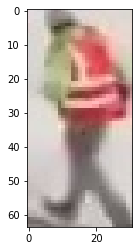

In [34]:
!pip3 install matplotlib==3.3.3
import matplotlib.pyplot as plt
from PIL import Image 
import os

DEMO_IMAGE = 'val/ppe3_008647_classes-not_in_harness-in_hardhat-in_vest-person_not_in_bucket_crop-01.jpg'
image_path = os.path.join(os.environ.get('LOCAL_DATA_DIR'), 'dataset_ppe/crops', DEMO_IMAGE)
plt.imshow(Image.open(image_path))
os.environ['DEMO_IMG_PATH'] = os.path.join(os.environ.get('DATA_DOWNLOAD_DIR'), 'dataset_ppe/crops/', DEMO_IMAGE)

In [35]:
!tao multitask_classification inference -m $USER_EXPERIMENT_DIR/resnet_pruned/weights/multitask_cls_resnet10_epoch_$EPOCH.tlt \
                                        -i $DEMO_IMG_PATH \
                                        -cm $USER_EXPERIMENT_DIR/class_mapping.json \
                                        -k $KEY

2022-03-24 15:47:41,992 [INFO] root: Registry: ['nvcr.io']
2022-03-24 15:47:42,140 [INFO] tlt.components.instance_handler.local_instance: Running command in container: nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.5-py3
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-tdj76nsk because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.
Using TensorFlow backend.

2022-03-24 22:47:48,521 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:153: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.


2022-03-24 22:47:48,603 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placehol

Task hardhat:
Predictions: [0.08071501 0.82158226 0.09770271]
Class name = in_hardhat
********
Task harness:
Predictions: [0.10359716 0.25293398 0.6434689 ]
Class name = not_in_harness
********
Task person_in_bucket:
Predictions: [0.00842721 0.99157286]
Class name = person_not_in_bucket
********
Task vest:
Predictions: [0.76142377 0.22420762 0.01436863]
Class name = in_vest
********
2022-03-24 15:47:56,641 [INFO] tlt.components.docker_handler.docker_handler: Stopping container.


## 10. Export and Deploy! <a class="anchor" id="head-10"></a>

You may export in FP32, FP16 or INT8 mode using the code block below. For INT8, you need to provide calibration image directory.

In [36]:
# tao <task> export will fail if .etlt already exists. So we clear the export folder before tao <task> export
!rm -rf $LOCAL_EXPERIMENT_DIR/export
!mkdir -p $LOCAL_EXPERIMENT_DIR/export
# Export in FP32 mode. Change --data_type to fp16 for FP16 mode
!tao multitask_classification export -m $USER_EXPERIMENT_DIR/resnet_pruned/weights/multitask_cls_resnet10_epoch_$EPOCH.tlt \
                                     -cm $USER_EXPERIMENT_DIR/class_mapping.json \
                                     -o $USER_EXPERIMENT_DIR/export/mcls_export.etlt \
                                     -k $KEY \
                                     --data_type fp32

# Uncomment to export in INT8 mode (generate calibration cache file). 
# !tao multitask_classification export -m $USER_EXPERIMENT_DIR/resnet_pruned/weights/multitask_cls_resnet10_epoch_$EPOCH.tlt \
#                                      -cm $USER_EXPERIMENT_DIR/class_mapping.json \
#                                      -o $USER_EXPERIMENT_DIR/export/mcls_export.etlt \
#                                      -k $KEY \
#                                      --cal_image_dir  $DATA_DOWNLOAD_DIR/imdb_processed/images \
#                                      --data_type int8 \
#                                      --batch_size 16 \
#                                      --batches 10 \
#                                      --cal_cache_file $USER_EXPERIMENT_DIR/export/cal.bin  \
#                                      --cal_data_file $USER_EXPERIMENT_DIR/export/cal.tensorfile

2022-03-24 15:49:12,788 [INFO] root: Registry: ['nvcr.io']
2022-03-24 15:49:12,945 [INFO] tlt.components.instance_handler.local_instance: Running command in container: nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.5-py3
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-dy2knjcu because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.
Using TensorFlow backend.
2022-03-24 22:49:20,957 [INFO] root: Using input nodes: ['input_1']
2022-03-24 22:49:20,957 [INFO] root: Using output nodes: ['hardhat/Softmax', 'harness/Softmax', 'person_in_bucket/Softmax', 'vest/Softmax']
2022-03-24 22:49:20,957 [INFO] iva.common.export.keras_exporter: Using input nodes: ['input_1']
2022-03-24 22:49:20,958 [INFO] iva.common.export.keras_exporter: Using output

In [ ]:
print('Exported model:')
print('------------')
!ls -lh $LOCAL_EXPERIMENT_DIR/export

You can now generate a TensorRT engine using `tao-converter`.

The `tao-converter` produces optimized tensorrt engines for the platform that it resides on. Therefore, to get maximum performance, please instantiate this docker and execute the `tao-converter` command, with the exported `.etlt` file and calibration cache (for int8 mode) on your target device. The tao-converter utility included in this docker only works for x86 devices, with discrete NVIDIA GPU's. 

For the jetson devices, please download the tao-converter for jetson from the dev zone link [here](https://developer.nvidia.com/tao-converter). 

If you choose to integrate your model into deepstream directly, you may do so by simply copying the exported `.etlt` file along with the calibration cache to the target device and updating the spec file that configures the `gst-nvinfer` element to point to this newly exported model. Usually this file is called `config_infer_primary.txt` for detection models and `config_infer_secondary_*.txt` for classification models.

In [ ]:
# For tao-converter, you need to provide input shape -d, which can be found in training spec file.
#   You also need to provide all output nodes -o. They are in the pattern `*task_name*/Softmax`,
#   the export command will also have it printed for your reference.

# Convert to TensorRT engine (FP32)
!tao converter -k $KEY \
                   -d 3,80,60 \
                   -o base_color/Softmax,category/Softmax,season/Softmax \
                   -e $USER_EXPERIMENT_DIR/export/trt.engine \
                   -m 16 \
                   -t fp32 \
                   -i nchw \
                   $USER_EXPERIMENT_DIR/export/mcls_export.etlt

# Convert to TensorRT engine (FP16)
# !tao converter -k $KEY \
#                    -d 3,80,60 \
#                    -o base_color/Softmax,category/Softmax,season/Softmax \
#                    -e $USER_EXPERIMENT_DIR/export/trt.engine \
#                    -m 16 \
#                    -t fp16 \
#                    -i nchw \
#                    $USER_EXPERIMENT_DIR/export/mcls_export.etlt

# Convert to TensorRT engine (INT8).
# !tao converter -k $KEY  \
#                    -d 3,80,60 \
#                    -o base_color/Softmax,category/Softmax,season/Softmax \
#                    -c $USER_EXPERIMENT_DIR/export/cal.bin \
#                    -e $USER_EXPERIMENT_DIR/export/trt.engine \
#                    -b 8 \
#                    -m 16 \
#                    -t int8 \
#                    -i nchw \
#                    $USER_EXPERIMENT_DIR/export/mcls_export.etlt